<a href="https://www.kaggle.com/code/yoanndev90/open-insect-id-notebook?scriptVersionId=293822310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 3.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Cette ligne est destinée à convertir un notebook importé en script Python, car l'import de scripts Python n'est pas directement possible via Kaggle.

```sh
!jupyter nbconvert --to python /kaggle/input/utility-scripts-80b72cee7e/__notebook__.ipynb --output-dir=/kaggle/working --output=utils
```

In [ ]:
!jupyter nbconvert --to python /kaggle/input/utility-scripts-80b72cee7e/__notebook__.ipynb --output-dir=/kaggle/working --output=utils

In [6]:
import os
import json
import glob
import re
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from collections import Counter, defaultdict
import ijson
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

In [3]:
import sys
sys.path.append('/kaggle/working')
from utils import *

imported_funcs = [name for name in dir() if not name.startswith('_') and callable(globals()[name])]
print("Fonctions importées :", imported_funcs)

Fonctions importées : ['Counter', 'DataLoader', 'Dataset', 'Path', 'ThreadPoolExecutor', 'as_completed', 'build_hierarchy_labels', 'build_taxa_maps', 'defaultdict', 'exit', 'get_ipython', 'parse_taxonomy', 'parse_taxonomy_folders', 'quit', 'save_hierarchy_map', 'scan_corrupted_images', 'tree', 'verify_image_validity']


In [4]:
from utils import parse_taxonomy, verify_image_validity

example = "train/train/00980_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Arctia_virginalis/464f3a34-4c04-4eb3-afa2-6cb7444c3fa3.jpg"
taxonomy = parse_taxonomy(example)
print("Résultat:", taxonomy)
validity = verify_image_validity(example)
print("Image valide" if validity else "Image invalide")

Résultat: {'ordre': 'Lepidoptera', 'famille': 'Erebidae', 'genre': 'Arctia', 'espece': 'virginalis'}
Image valide


In [6]:
from utils import tree

# total = tree(''/kaggle/input/inaturalist-insects/'', 2)                   # Très long temps d'attente (30min-1h)
total = tree('/kaggle/input/inaturalist-insects/val-json/', 2)
print(f"\nNombre total de fichiers : {total}")


Nombre total de fichiers : 1


In [22]:
import ijson

def load_annotated_images(json_path):
    """Charge lat/lon par file_name depuis train_mini_json ou train_json."""
    annotated = {}
    with open(json_path, 'rb') as f:
        parser = ijson.items(f, 'images.item')
        for img in parser:
            filename = img.get('file_name', '')
            lat = float(img.get('latitude')) if img.get('latitude') is not None else 0.0
            lon = float(img.get('longitude')) if img.get('longitude') is not None else 0.0
            annotated[filename] = (lat, lon)
    return annotated

In [23]:
from collections import Counter

def compute_stats(full_taxa_map, full_geo_db, species_encountered):
    """Calcule toutes stats."""
    ordre_count = Counter()
    famille_count = Counter()
    genre_count = Counter()
    espece_count = Counter()
    
    for taxon_key, hier in full_taxa_map.items():
        ordre_count[hier['ordre']] += 1
        famille_count[hier['famille']] += 1
        genre_count[hier['genre']] += 1
        espece_count[hier['espece']] += 1
    
    homonyms_count = len([s for s in species_encountered if len(species_encountered[s]) > 1])
    homonyms_dirs = sum(len(species_encountered[s]) for s in species_encountered if len(species_encountered[s]) > 1)
    
    taxon_geo_counts = {str(k): len(v) for k, v in full_geo_db.items()}
    geo_taxa = len(full_geo_db)
    total_taxa = len(full_taxa_map)
    multi_geo = sum(1 for c in taxon_geo_counts.values() if c > 1)
    
    return {
        'total_dirs': len(species_encountered),
        'unique_taxa': total_taxa,
        'geo_coverage': geo_taxa / total_taxa if total_taxa else 0,
        'homonyms': {'names': homonyms_count, 'dirs': homonyms_dirs},
        'hierarchy': {
            'ordres': len(ordre_count), 'familles': len(famille_count), 'genres': len(genre_count)
        },
        'taxon_geo_counts': taxon_geo_counts
    }, ordre_count, famille_count, genre_count

In [ ]:
from utils import parse_taxonomy_folders, build_taxa_maps

annotated_images = load_annotated_images('/kaggle/input/inaturalist-insects/train-json/train.json')
species_encountered, unparsed_dirs = parse_taxonomy_folders('/kaggle/input/inaturalist-insects/train/train/')
full_taxa_map, full_geo_db = build_taxa_maps(species_encountered, annotated_images, '/kaggle/input/inaturalist-insects/train/train/')
stats, ordre_count, famille_count, genre_count = compute_stats(full_taxa_map, full_geo_db, species_encountered)

print(f"✅ {stats['unique_taxa']} taxons (sur {stats['total_dirs']} dossiers)")
print(f"Homonymes: {stats['homonyms']['names']} noms => {stats['homonyms']['dirs']} dossiers")
print(f"Hiérarchie: {stats['hierarchy']['ordres']} ordres, {stats['hierarchy']['familles']} familles, {stats['hierarchy']['genres']} genres")
print(f"Géo: {len(full_geo_db)}/{len(full_taxa_map)} ({stats['geo_coverage']*100:.1f}%)")
print(f"Non parsés: {len(unparsed_dirs)}")


save_hierarchy_map(full_taxa_map, full_geo_db, stats, 'hierarchy_map.json')

In [10]:
from utils import build_hierarchy_labels

data_dir = '/kaggle/input/inaturalist-insects/'
hierarchy_map_file = '/kaggle/working/hierarchy_map.json'
final_hierarchy = build_hierarchy_labels(data_dir, hierarchy_map_file)

print("\nExemples:")
for idx in range(5):
    labels = final_hierarchy.get(idx)
    print(f"Class {idx}: {labels}") # [ordre_id, famille_id, genre_id, espece_id]

Classes: 2526 (scan /kaggle/input/inaturalist-insects/train_mini/train_mini)
Hiérarchie: 17 ordres, 190 fam., 1472 genres
✅ 2526/2526 mappées
💾 hierarchy_labels.json prêt pour training

Exemples:
Class 0: [0, 21, 124, 0]
Class 1: [0, 21, 1048, 1]
Class 2: [0, 21, 1219, 2]
Class 3: [0, 23, 185, 3]
Class 4: [0, 23, 1090, 4]


In [9]:
class RobustImageFolder(Dataset):
    """ImageFolder skip corrompus."""
    def __init__(self, root, transform=None, corrupt_files=None):
        self.root = root
        self.transform = transform
        self.corrupt_files = set(corrupt_files or [])
        
        self.classes, self.class_to_idx = self.find_classes(self.root)
        self.samples = self.make_dataset(self.root, self.class_to_idx)
        
        self.valid_indices = []
        for i, (path, _) in enumerate(self.samples):
            if os.path.relpath(path, self.root) not in self.corrupt_files:
                self.valid_indices.append(i)
    
    def find_classes(self, directory):
        """Trouve classes (dossiers)."""
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def make_dataset(self, directory, class_to_idx):
        """Construit samples comme ImageFolder."""
        samples = []
        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_index)
                    samples.append(item)
        return samples
    
    def __getitem__(self, index):
        path, target = self.samples[self.valid_indices[index]]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def __len__(self):
        return len(self.valid_indices)

In [15]:
from utils import scan_corrupted_images

corrupted_train, train_log = scan_corrupted_images('/kaggle/input/inaturalist-insects/train/train', max_workers=4)
corrupted_val, val_log = scan_corrupted_images('/kaggle/input/inaturalist-insects/val/val', max_workers=4)

with open(train_log) as f:
    print("\nCORROMPUS TRAIN:\n", f.read()[:500] + "..." if os.path.getsize(train_log) > 500 else f.read())

Scan 126300 JPG dans /kaggle/input/inaturalist-insects/train_mini/train_mini
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (115 bytes not processed)
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (43 bytes not processed)
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (124 bytes not processed)
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: OSError: image file is truncated (62 bytes not processed)
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: OSError: image file is truncated

In [2]:
corrupt_train = []
with open('/kaggle/working/corrupted_train.txt') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            corrupt_train.append(line.strip())

corrupt_val = []
with open('/kaggle/working/corrupted_val.txt') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            corrupt_val.append(line.strip())

In [7]:
class HierarchicalInsectDataset(Dataset):
    def __init__(self, root_dir, hierarchy_map, transform=None, corrupt_files=None):
        self.root_dir = root_dir
        self.hierarchy_map = hierarchy_map
        self.transform = transform
        
        self.inner_dataset = datasets.ImageFolder(root_dir)
        
        self.valid_indices = []
        for i in range(len(self.inner_dataset)):
            class_idx = self.inner_dataset.targets[i]
            if class_idx in self.hierarchy_map:
                # Skip si basename dans corrupt_files
                path = self.inner_dataset.samples[i][0]
                if os.path.basename(path) not in (corrupt_files or []):
                    self.valid_indices.append(i)
        
        print(f"Dataset {root_dir}: {len(self.inner_dataset)} → {len(self.valid_indices)} valides")
    
    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        img, class_idx = self.inner_dataset[real_idx]
        
        # Labels hiérarchiques [ordre_id, famille_id, genre_id, espece_id]
        hier_labels = torch.tensor(self.hierarchy_map[class_idx])
        
        if self.transform:
            img = self.transform(img)
        
        return img, hier_labels
    
    def __len__(self):
        return len(self.valid_indices)

In [14]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = HierarchicalInsectDataset(
    '/kaggle/input/inaturalist-insects/train/train', 
    final_hierarchy, 
    transform=train_transforms,
    corrupt_files=[os.path.basename(p) for p in corrupt_train]
)

val_dataset = HierarchicalInsectDataset(
    '/kaggle/input/inaturalist-insects/val/val', 
    final_hierarchy, 
    transform=val_transforms,
    corrupt_files=[os.path.basename(p) for p in corrupt_val]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Datasets hiérarchiques:")
print(f"  Train: {len(train_dataset)} images, 2526 classes")
print(f"  Val: {len(val_dataset)} images")
print(f"  Labels: ordre/famille/genre/espece [device={device}]")

img, labels = next(iter(train_loader))
print(f"Batch shape: {img.shape}, labels shape: {labels.shape}")  # [32,3,224,224], [32,4]

Dataset /kaggle/input/inaturalist-insects/train_mini/train_mini: 126300 → 126245 valides
Dataset /kaggle/input/inaturalist-insects/val/val: 25260 → 25260 valides
✅ Datasets hiérarchiques:
  Train: 126245 images, 2526 classes
  Val: 25260 images
  Labels: ordre/famille/genre/espece [device=cuda]
Batch shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32, 4])


In [15]:
class HierarchicalMobileNetV3(nn.Module):
    """MobileNetV3 avec outputs séparés par niveau."""
    def __init__(self, num_ordre=17, num_famille=190, num_genre=1472, num_espece=2526):
        super().__init__()
        backbone = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        
        self.fc_shared = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3)
        )
        
        # Heads indépendants (FIX: pas cumulatif)
        self.head_ordre = nn.Linear(512, num_ordre)
        self.head_famille = nn.Linear(512, num_famille)
        self.head_genre = nn.Linear(512, num_genre)
        self.head_espece = nn.Linear(512, num_espece)
    
    def forward(self, x, return_probs=False):
        x = self.features(x)
        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        shared = self.fc_shared(feats)
        
        ordre = self.head_ordre(shared)
        famille = self.head_famille(shared)
        genre = self.head_genre(shared)
        espece = self.head_espece(shared)
        
        if return_probs:
            return (F.softmax(ordre, dim=1), F.softmax(famille, dim=1), 
                   F.softmax(genre, dim=1), F.softmax(espece, dim=1))
        
        max_classes = 2526
        preds = torch.zeros(x.size(0), 4, max_classes, device=x.device)
        preds[:, 0, :ordre.size(1)] = ordre
        preds[:, 1, :famille.size(1)] = famille
        preds[:, 2, :genre.size(1)] = genre
        preds[:, 3, :espece.size(1)] = espece
        
        return preds  # [B,4,2526]

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import json

with open('hierarchy_labels.json') as f:
    stats = json.load(f)['stats']
    
num_ordre = stats['ordres']      # 17
num_famille = stats['familles']  # 190
num_genre = stats['genres']     # 1472
num_espece = stats['total_classes']  # 2526

model = HierarchicalMobileNetV3(num_ordre, num_famille, num_genre, num_espece).to(device)

print(f"Model: {sum(p.numel() for p in model.parameters()):,} params")
print(f"✅ GPU: {next(model.parameters()).device}")

model.eval()
with torch.no_grad():
    batch_img, batch_labels = next(iter(train_loader))
    preds = model(batch_img.to(device))  # [32,4,2526]
    loss = criterion(preds, batch_labels.to(device))
    print(f"✅ Test OK: preds={preds.shape}, loss={loss.item():.3f}")

Model: 5,622,173 params
✅ GPU: cuda:0
✅ Test OK: preds=torch.Size([32, 4, 2526]), loss=7.147


In [17]:
class HierarchicalLoss(nn.Module):
    def __init__(self, num_classes_per_level):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.weights = torch.tensor([1.0, 2.0, 5.0, 10.0])
        self.num_classes = num_classes_per_level  # [17,190,1472,2526]
    
    def forward(self, preds, targets):
        loss = 0
        for i in range(4):
            mask = torch.arange(self.num_classes[i], device=preds.device)
            lvl_pred = preds[:, i, mask]
            lvl_loss = self.ce(lvl_pred, targets[:, i])
            loss += self.weights[i] * lvl_loss
        return loss / self.weights.sum()

criterion = HierarchicalLoss([num_ordre, num_famille, num_genre, num_espece])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Labels shape: torch.Size([32, 4]), dtype: torch.int64
Sample labels[0]: tensor([  0,  21, 124,   0], device='cuda:0')
preds shape: torch.Size([32, 4, 2526])
🚀 Début entraînement hiérarchique


Epoch  0: 100%|██████████| 3946/3946 [14:41<00:00,  4.48it/s, loss=4.2752]


Epoch  0: Train=4.2871 | Val=3.3380
  Accs - Ordre:0.8377 | Fam:0.5916 | Genre:0.3169 | Esp:0.2941


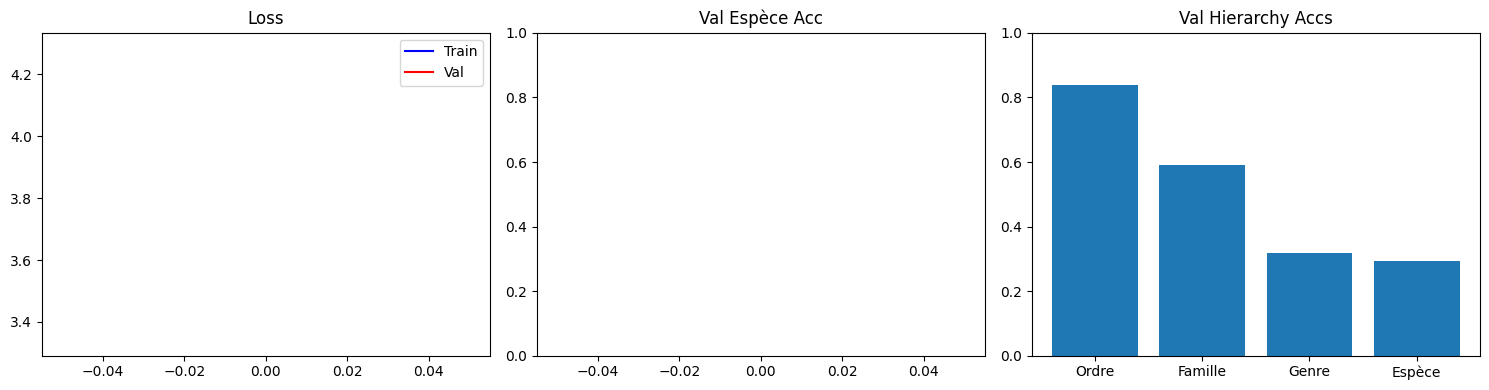

🔥 BEST: Esp.Acc=0.2941


Epoch  1: 100%|██████████| 3946/3946 [14:50<00:00,  4.43it/s, loss=3.9743]


Epoch  1: Train=3.3498 | Val=2.6429
  Accs - Ordre:0.8574 | Fam:0.6368 | Genre:0.4253 | Esp:0.4026


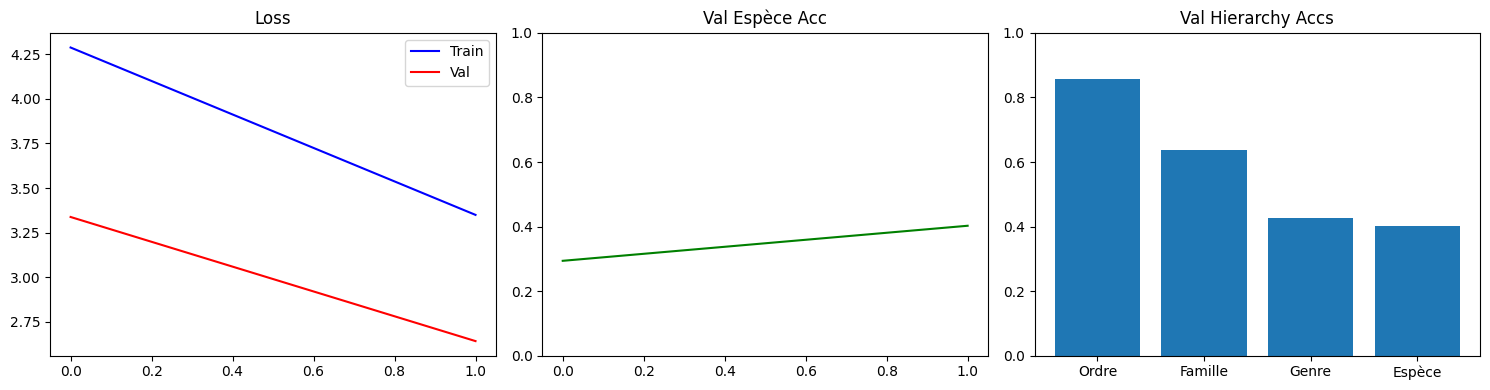

🔥 BEST: Esp.Acc=0.4026


Epoch  2: 100%|██████████| 3946/3946 [14:43<00:00,  4.47it/s, loss=4.2375]


Epoch  2: Train=2.7887 | Val=2.2174
  Accs - Ordre:0.8668 | Fam:0.6681 | Genre:0.5089 | Esp:0.4757


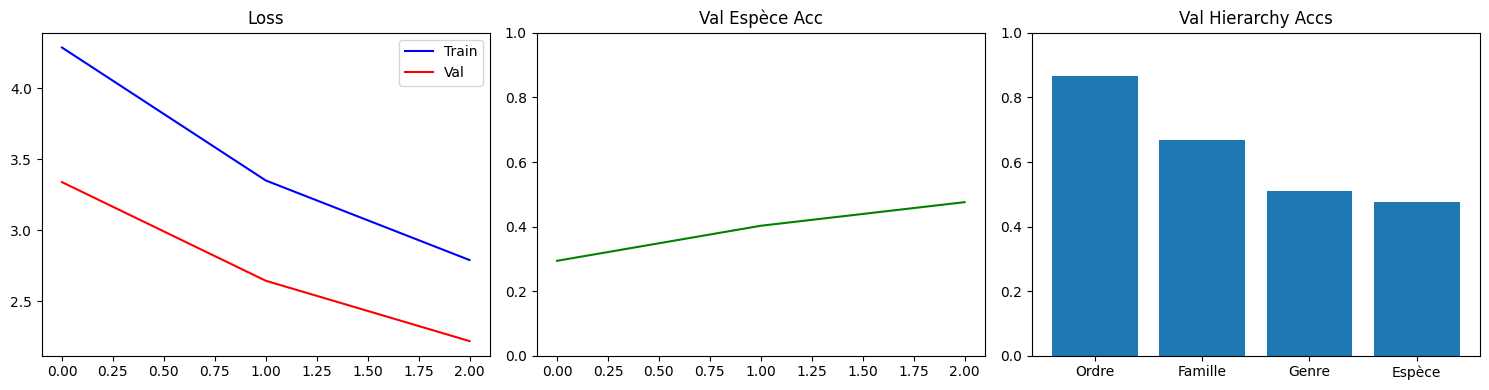

🔥 BEST: Esp.Acc=0.4757


Epoch  3: 100%|██████████| 3946/3946 [14:46<00:00,  4.45it/s, loss=3.5917]


Epoch  3: Train=2.4282 | Val=1.9575
  Accs - Ordre:0.8768 | Fam:0.6908 | Genre:0.5586 | Esp:0.5169


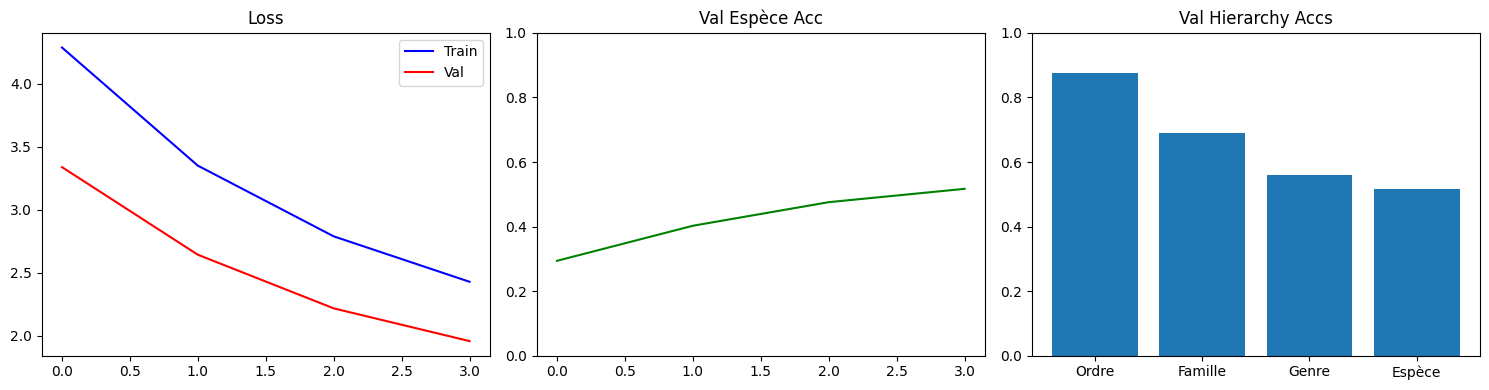

🔥 BEST: Esp.Acc=0.5169


Epoch  4: 100%|██████████| 3946/3946 [15:15<00:00,  4.31it/s, loss=2.0400]


Epoch  4: Train=2.1945 | Val=1.8358
  Accs - Ordre:0.8782 | Fam:0.7030 | Genre:0.5843 | Esp:0.5288


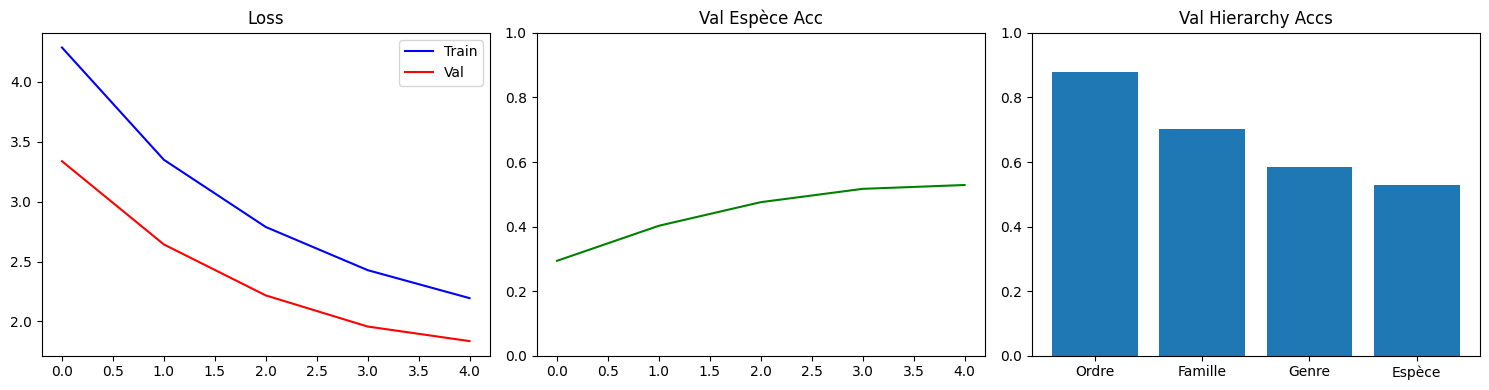

🔥 BEST: Esp.Acc=0.5288


Epoch  5: 100%|██████████| 3946/3946 [14:56<00:00,  4.40it/s, loss=2.1264]


Epoch  5: Train=2.0094 | Val=1.6913
  Accs - Ordre:0.8813 | Fam:0.7215 | Genre:0.6139 | Esp:0.5583


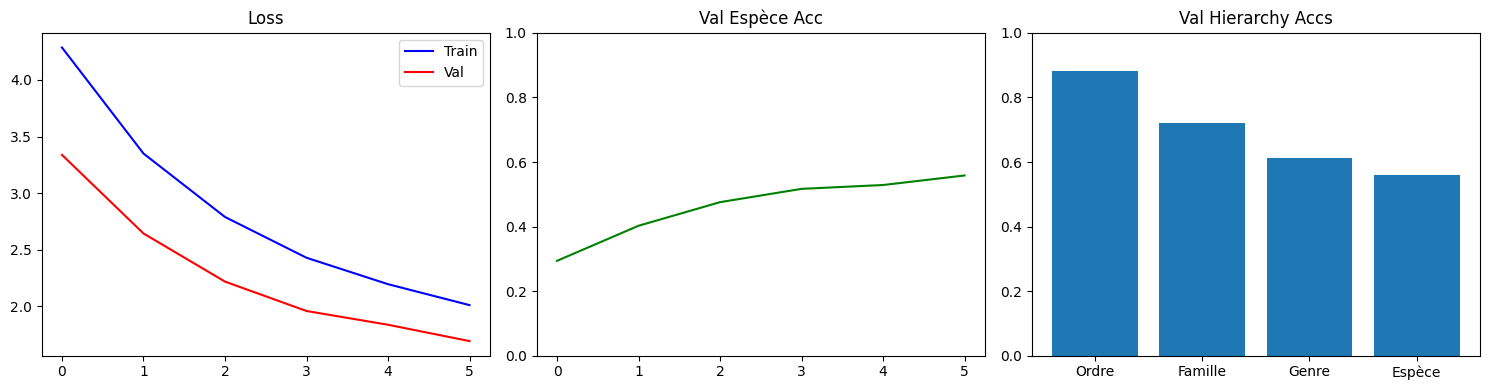

🔥 BEST: Esp.Acc=0.5583


Epoch  6: 100%|██████████| 3946/3946 [14:28<00:00,  4.55it/s, loss=3.1302]


Epoch  6: Train=1.8717 | Val=1.6075
  Accs - Ordre:0.8835 | Fam:0.7297 | Genre:0.6325 | Esp:0.5727


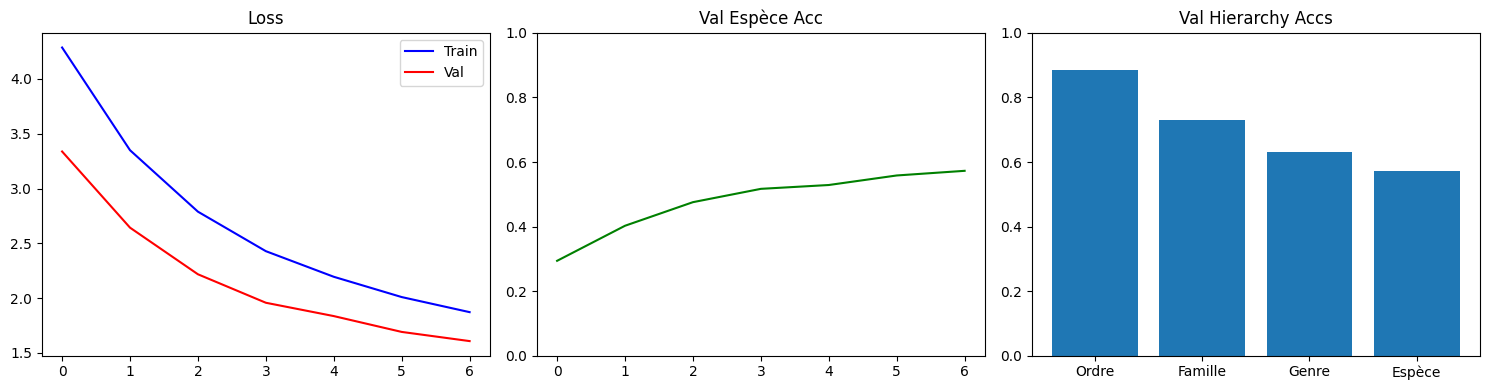

🔥 BEST: Esp.Acc=0.5727


Epoch  7: 100%|██████████| 3946/3946 [14:34<00:00,  4.51it/s, loss=1.6285]


Epoch  7: Train=1.7805 | Val=1.5330
  Accs - Ordre:0.8874 | Fam:0.7410 | Genre:0.6471 | Esp:0.5894


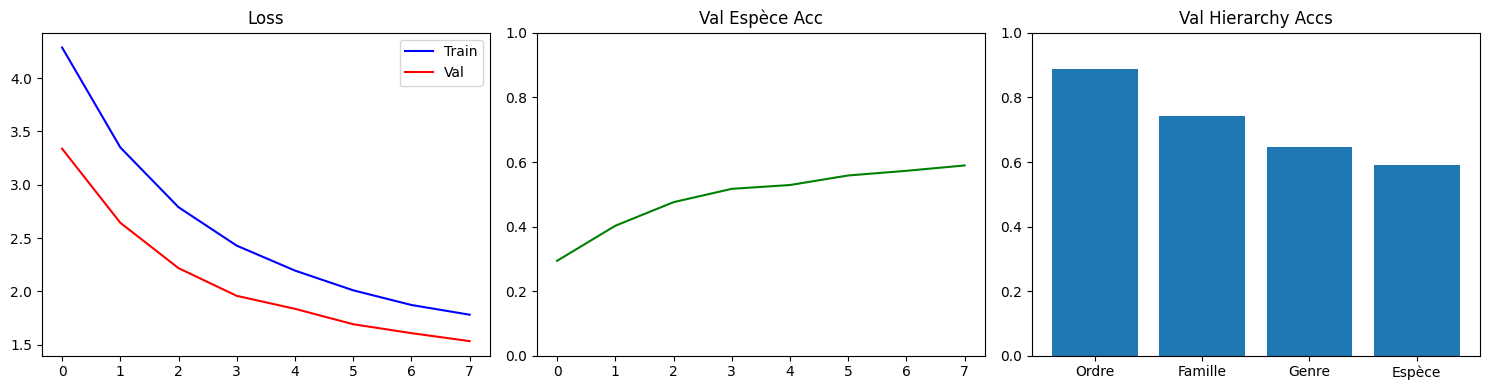

🔥 BEST: Esp.Acc=0.5894


Epoch  8: 100%|██████████| 3946/3946 [14:32<00:00,  4.52it/s, loss=1.6644]


Epoch  8: Train=1.6723 | Val=1.4660
  Accs - Ordre:0.8905 | Fam:0.7502 | Genre:0.6600 | Esp:0.6040


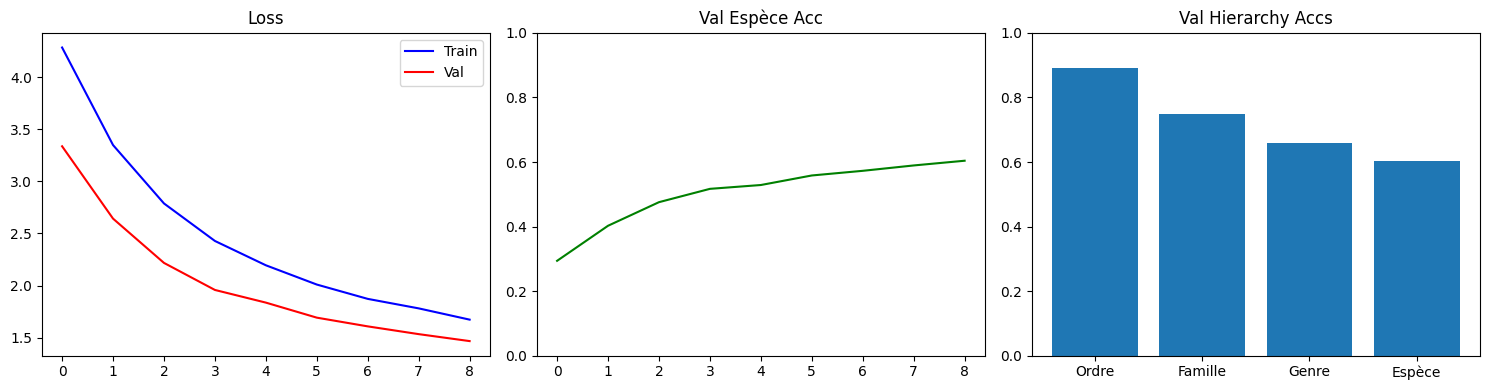

🔥 BEST: Esp.Acc=0.6040


Epoch  9: 100%|██████████| 3946/3946 [14:19<00:00,  4.59it/s, loss=1.9929]


Epoch  9: Train=1.5514 | Val=1.4210
  Accs - Ordre:0.8926 | Fam:0.7538 | Genre:0.6720 | Esp:0.6096


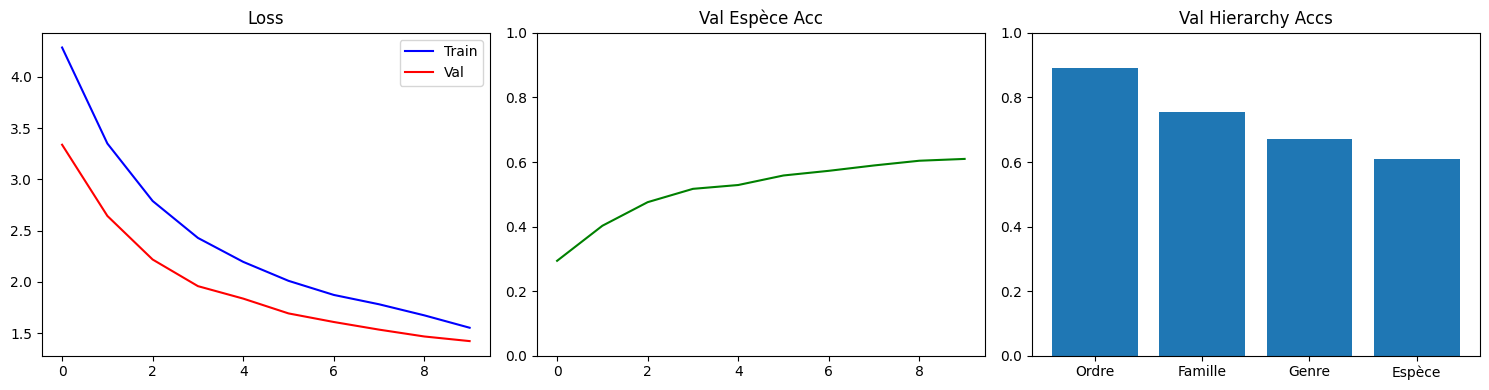

/tmp/ipykernel_55/1069506765.py:109: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/tmp/ipykernel_55/312458342.py:33: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_probs:


RuntimeError: number of output names provided (8) exceeded number of outputs (1)

In [30]:
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")
print(f"Sample labels[0]: {labels[0]}")
print(f"preds shape: {preds.shape}")

criterion = HierarchicalLoss([num_ordre, num_famille, num_genre, num_espece])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-6)
scaler = GradScaler('cuda')

best_val_acc = 0
patience_counter = 0
patience = 10

train_losses, val_losses, val_accs = [], [], []
hierarchy_accs = {'ordre': [], 'famille': [], 'genre': [], 'espece': []}  # Track real hierarchy accs

print("🚀 Début entraînement hiérarchique")

for epoch in range(50):
    # === TRAIN ===
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:2d}')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast('cuda'):
            preds = model(images)  # [B,4,2526]
            loss = criterion(preds, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    
    # === VAL ===
    model.eval()
    val_loss_total = 0
    val_correct = [0,0,0,0]  # [ordre, famille, genre, espèce]
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss_total += loss.item()
        
            for lvl in range(4):
                logits = preds[:, lvl, :criterion.num_classes[lvl]]
                lvl_preds = logits.argmax(1)
                val_correct[lvl] += (lvl_preds == labels[:, lvl]).sum().item()
        
            val_total += labels.size(0)

    avg_val_loss = val_loss_total / len(val_loader)
    hierarchy_accs_current = {
        'ordre': val_correct[0]/val_total,
        'famille': val_correct[1]/val_total,
        'genre': val_correct[2]/val_total,
        'espece': val_correct[3]/val_total
    }
    val_acc = hierarchy_accs_current['espece']
    
    print(f"Epoch {epoch:2d}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    print(f"  Accs - Ordre:{hierarchy_accs_current['ordre']:.4f} | Fam:{hierarchy_accs_current['famille']:.4f} | "
          f"Genre:{hierarchy_accs_current['genre']:.4f} | Esp:{val_acc:.4f}")
    
    # Update tracking lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    for k in hierarchy_accs:
        hierarchy_accs[k].append(hierarchy_accs_current[k])
    
    # PLOT avec vraies accuracies
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); 
    plt.plot(train_losses, 'b-', label='Train'); plt.plot(val_losses, 'r-', label='Val'); plt.legend(); plt.title('Loss')
    plt.subplot(1,3,2); plt.plot(val_accs, 'g-'); plt.title('Val Espèce Acc'); plt.ylim(0,1)
    plt.subplot(1,3,3); 
    keys = ['Ordre','Famille','Genre','Espèce']
    accs = [hierarchy_accs_current['ordre'], hierarchy_accs_current['famille'], 
            hierarchy_accs_current['genre'], hierarchy_accs_current['espece']]
    plt.bar(keys, accs); plt.title('Val Hierarchy Accs'); plt.ylim(0,1)
    plt.tight_layout(); plt.show()
    
    # EXPORT ONNX toutes les 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        
        # Test forward pour voir les vraies outputs
        with torch.no_grad():
            test_output = model(dummy_input)
            print(f"Model outputs shape: {test_output.shape if isinstance(test_output, torch.Tensor) else [o.shape for o in test_output]}")
        
        # Export simple (1 input → 1 output principal)
        torch.onnx.export(
            model, 
            dummy_input, 
            f"onnx/insect_model_epoch_{epoch+1}.onnx",
            export_params=True, 
            opset_version=17,  # +récent = mieux support
            do_constant_folding=True,
            input_names=['image'],
            output_names=['logits'],  # 1 seul output
            dynamic_axes={
                'image': {0: 'batch_size'},
                'logits': {0: 'batch_size'}
            }
        )
        print(f"💾 ONNX exported: onnx/insect_model_epoch_{epoch+1}.onnx")

    
    # SAVE BEST
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc,
            'hierarchy_accs': hierarchy_accs_current,
            'stats': {'train_losses': train_losses.copy(), 'val_losses': val_losses.copy(), 
                     'val_accs': val_accs.copy(), 'hierarchy_accs': hierarchy_accs.copy()}
        }, 'best_hier_model.pth')
        print(f"🔥 BEST: Esp.Acc={val_acc:.4f}")
    else:
        patience_counter += 1
    
    scheduler.step(avg_val_loss)
    
    if patience_counter >= patience:
        print(f"🛑 Early Stop at epoch {epoch}")
        break

print(f"🏆 FINAL: Best Espèce Acc = {best_val_acc:.4f}")

Labels shape: torch.Size([32, 4]), dtype: torch.int64
Sample labels[0]: tensor([  7,  22, 184, 677], device='cuda:0')
preds shape: torch.Size([32, 4, 2526])
✅ Repris epoch 27, Best Acc: 0.6709
📊 History: 36 epochs déjà faits
🚀 Début entraînement hiérarchique


Epoch  0: 100%|██████████| 3946/3946 [20:12<00:00,  3.25it/s, loss=0.6520]


Epoch  0: Train=0.5114 | Val=1.2008
  Accs - Ordre:0.9081 | Fam:0.8102 | Genre:0.7414 | Esp:0.6697


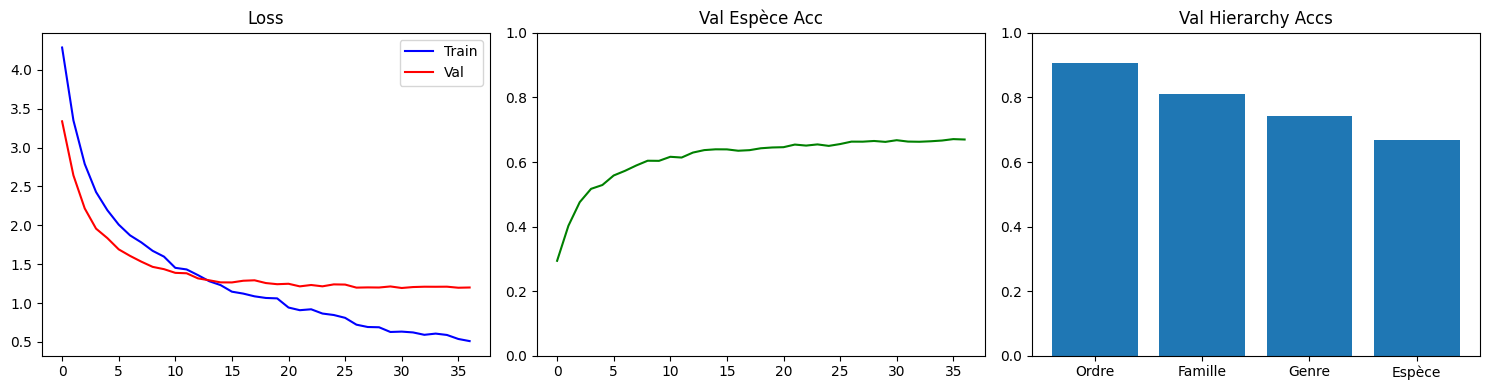

Epoch  1: 100%|██████████| 3946/3946 [13:52<00:00,  4.74it/s, loss=1.5272]


Epoch  1: Train=0.5103 | Val=1.2044
  Accs - Ordre:0.9077 | Fam:0.8106 | Genre:0.7405 | Esp:0.6687


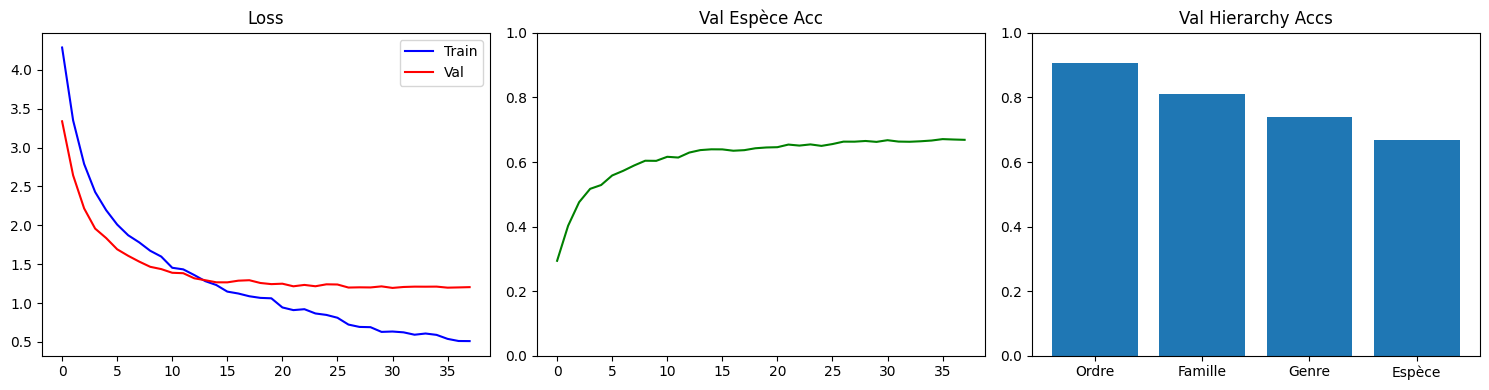

Epoch  2: 100%|██████████| 3946/3946 [13:39<00:00,  4.82it/s, loss=0.8765]


Epoch  2: Train=0.5108 | Val=1.2108
  Accs - Ordre:0.9089 | Fam:0.8116 | Genre:0.7399 | Esp:0.6667


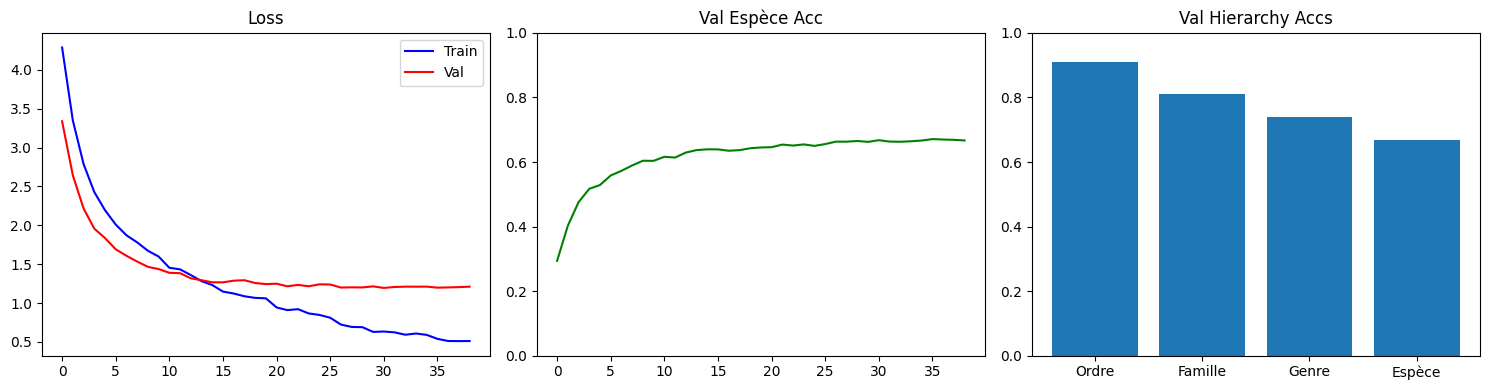

Epoch  3: 100%|██████████| 3946/3946 [13:23<00:00,  4.91it/s, loss=0.9647]


Epoch  3: Train=0.4854 | Val=1.2062
  Accs - Ordre:0.9088 | Fam:0.8123 | Genre:0.7409 | Esp:0.6686


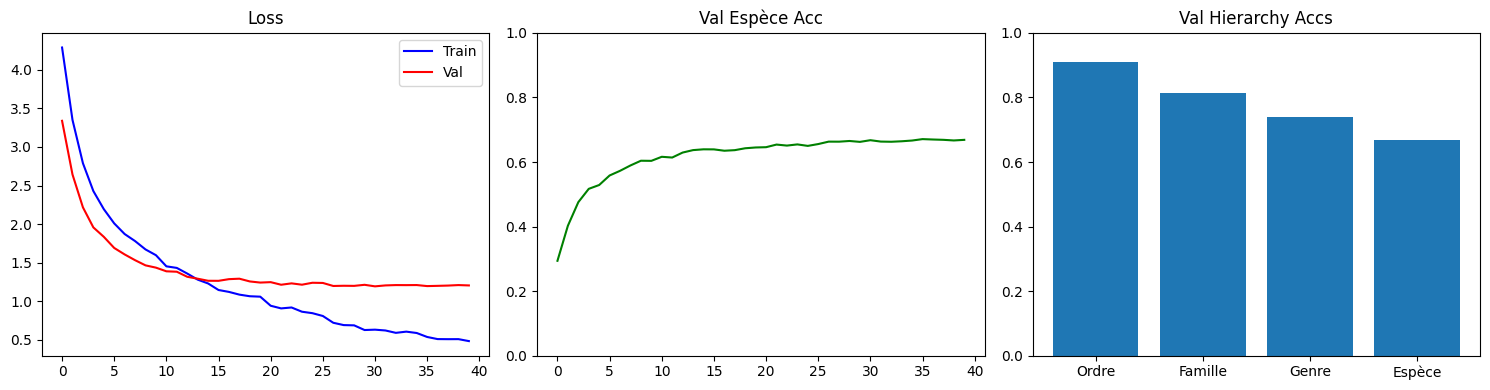

Epoch  4: 100%|██████████| 3946/3946 [13:21<00:00,  4.93it/s, loss=1.4262]


Epoch  4: Train=0.4866 | Val=1.2094
  Accs - Ordre:0.9089 | Fam:0.8112 | Genre:0.7413 | Esp:0.6674


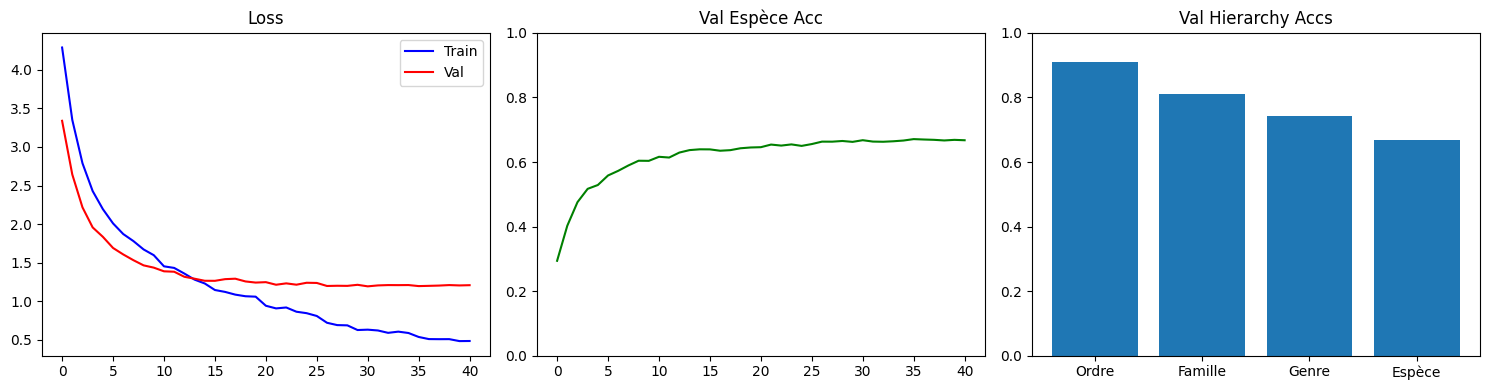

Epoch  5: 100%|██████████| 3946/3946 [13:43<00:00,  4.79it/s, loss=0.8629]


Epoch  5: Train=0.4636 | Val=1.2042
  Accs - Ordre:0.9090 | Fam:0.8119 | Genre:0.7420 | Esp:0.6705


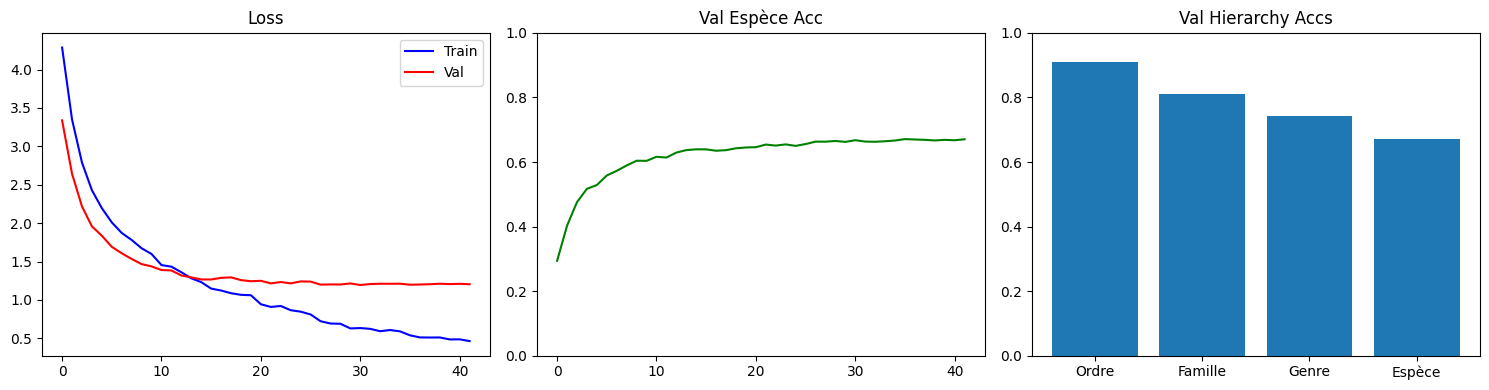

Epoch  6: 100%|██████████| 3946/3946 [14:10<00:00,  4.64it/s, loss=1.8952]


Epoch  6: Train=0.4568 | Val=1.2061
  Accs - Ordre:0.9090 | Fam:0.8126 | Genre:0.7410 | Esp:0.6706


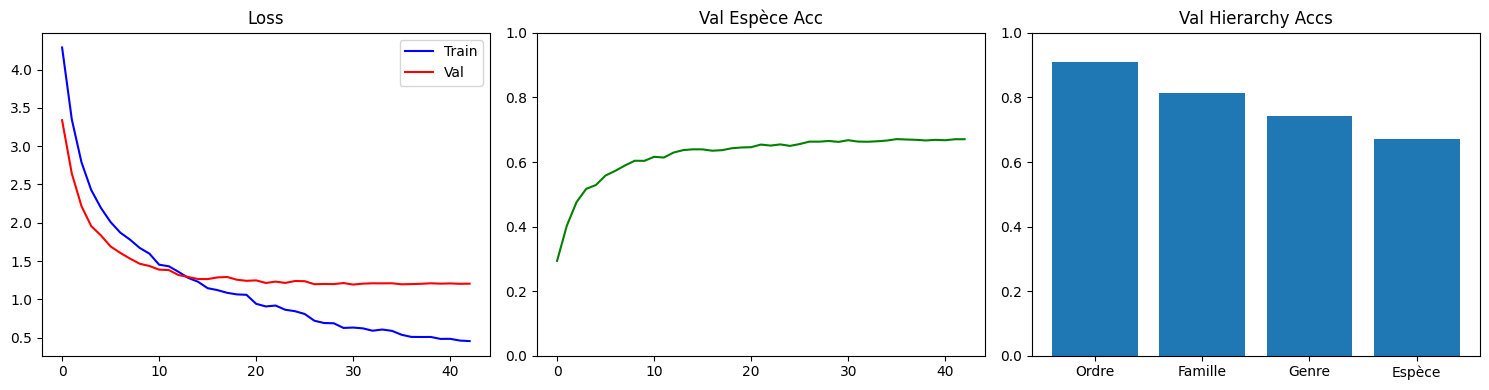

Epoch  7: 100%|██████████| 3946/3946 [14:28<00:00,  4.54it/s, loss=1.0204]


Epoch  7: Train=0.4565 | Val=1.2028
  Accs - Ordre:0.9097 | Fam:0.8128 | Genre:0.7417 | Esp:0.6721


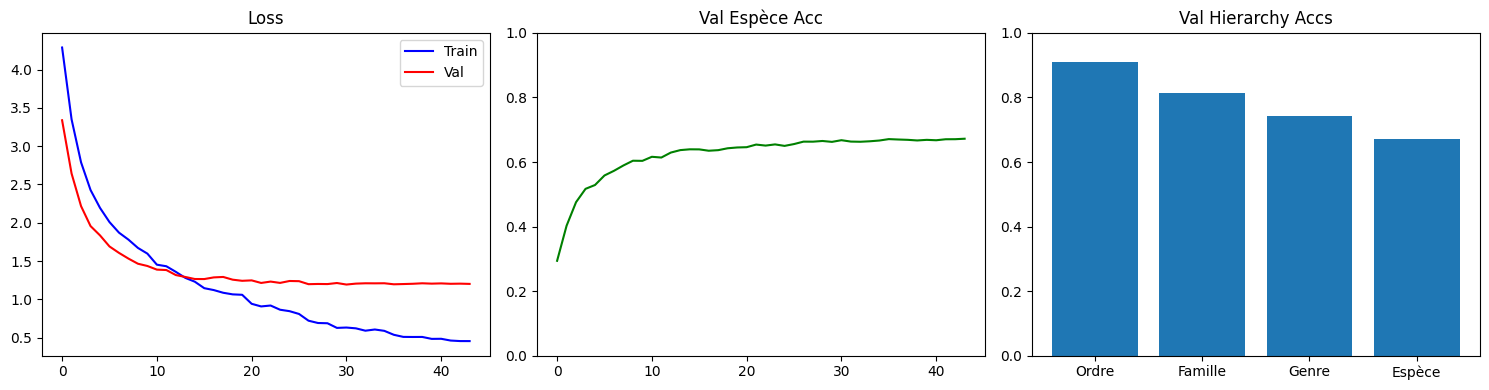

🔥 BEST: Esp.Acc=0.6721


Epoch  8: 100%|██████████| 3946/3946 [14:34<00:00,  4.51it/s, loss=2.2180]


Epoch  8: Train=0.4516 | Val=1.2092
  Accs - Ordre:0.9082 | Fam:0.8131 | Genre:0.7421 | Esp:0.6704


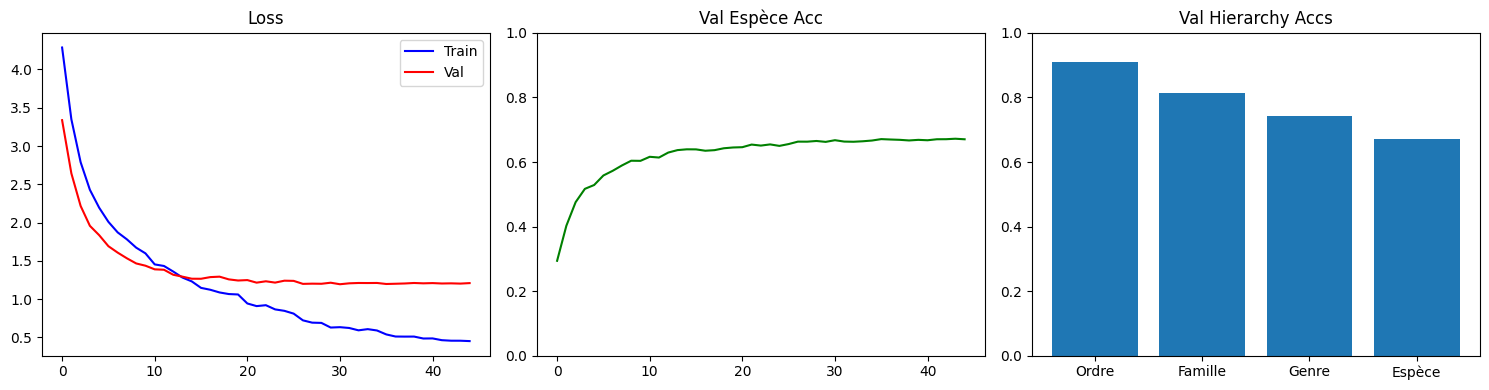

Epoch  9: 100%|██████████| 3946/3946 [13:46<00:00,  4.77it/s, loss=1.1628]


Epoch  9: Train=0.4383 | Val=1.2049
  Accs - Ordre:0.9098 | Fam:0.8143 | Genre:0.7418 | Esp:0.6705


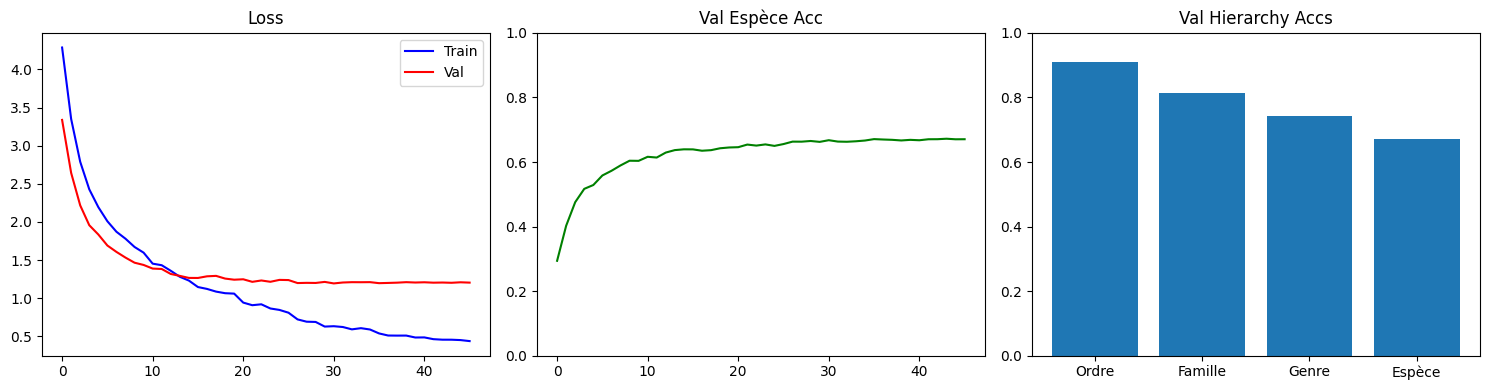

Model outputs shape: torch.Size([1, 4, 2526])


/tmp/ipykernel_55/1596543611.py:132: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/tmp/ipykernel_55/312458342.py:33: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_probs:


💾 ONNX exported: insect_model_epoch_10.onnx


Epoch 10:  83%|████████▎ | 3269/3946 [11:32<02:23,  4.72it/s, loss=0.5989]


KeyboardInterrupt: 

In [21]:
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")
print(f"Sample labels[0]: {labels[0]}")
print(f"preds shape: {preds.shape}")

criterion = HierarchicalLoss([num_ordre, num_famille, num_genre, num_espece])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-6)
scaler = GradScaler('cuda')

checkpoint = torch.load('/kaggle/working/best_hier_model.pth', map_location=device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optim'])

best_val_acc = 0
patience_counter = 0
patience = 10

train_losses, val_losses, val_accs = [], [], []
hierarchy_accs = {'ordre': [], 'famille': [], 'genre': [], 'espece': []}  # Track real hierarchy accs

start_epoch = checkpoint['epoch'] + 1
best_val_acc = checkpoint['val_acc']
train_losses, val_losses, val_accs = checkpoint['stats']['train_losses'], checkpoint['stats']['val_losses'], checkpoint['stats']['val_accs']

# Hierarchy accs history si disponible
if 'hierarchy_accs' in checkpoint['stats']:
    hierarchy_accs.update({k: v[-1:] for k, v in checkpoint['stats']['hierarchy_accs'].items()})

print(f"✅ Repris epoch {start_epoch}, Best Acc: {best_val_acc:.4f}")
print(f"📊 History: {len(train_losses)} epochs déjà faits")

print("🚀 Début entraînement hiérarchique")

for epoch in range(start_epoch,50):
    # === TRAIN ===
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:2d}')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast('cuda'):
            preds = model(images)  # [B,4,2526]
            loss = criterion(preds, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    
    # === VAL ===
    model.eval()
    val_loss_total = 0
    val_correct = [0,0,0,0]  # [ordre, famille, genre, espèce]
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss_total += loss.item()
        
            for lvl in range(4):
                logits = preds[:, lvl, :criterion.num_classes[lvl]]
                lvl_preds = logits.argmax(1)
                val_correct[lvl] += (lvl_preds == labels[:, lvl]).sum().item()
        
            val_total += labels.size(0)

    avg_val_loss = val_loss_total / len(val_loader)
    hierarchy_accs_current = {
        'ordre': val_correct[0]/val_total,
        'famille': val_correct[1]/val_total,
        'genre': val_correct[2]/val_total,
        'espece': val_correct[3]/val_total
    }
    val_acc = hierarchy_accs_current['espece']
    
    print(f"Epoch {epoch:2d}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    print(f"  Accs - Ordre:{hierarchy_accs_current['ordre']:.4f} | Fam:{hierarchy_accs_current['famille']:.4f} | "
          f"Genre:{hierarchy_accs_current['genre']:.4f} | Esp:{val_acc:.4f}")
    
    # Update tracking lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    for k in hierarchy_accs:
        hierarchy_accs[k].append(hierarchy_accs_current[k])
    
    # PLOT avec vraies accuracies
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); 
    plt.plot(train_losses, 'b-', label='Train'); plt.plot(val_losses, 'r-', label='Val'); plt.legend(); plt.title('Loss')
    plt.subplot(1,3,2); plt.plot(val_accs, 'g-'); plt.title('Val Espèce Acc'); plt.ylim(0,1)
    plt.subplot(1,3,3); 
    keys = ['Ordre','Famille','Genre','Espèce']
    accs = [hierarchy_accs_current['ordre'], hierarchy_accs_current['famille'], 
            hierarchy_accs_current['genre'], hierarchy_accs_current['espece']]
    plt.bar(keys, accs); plt.title('Val Hierarchy Accs'); plt.ylim(0,1)
    plt.tight_layout(); plt.show()
    
    # EXPORT ONNX toutes les 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        
        # Test forward pour voir les vraies outputs
        with torch.no_grad():
            test_output = model(dummy_input)
            print(f"Model outputs shape: {test_output.shape if isinstance(test_output, torch.Tensor) else [o.shape for o in test_output]}")
        
        # Export simple (1 input → 1 output principal)
        torch.onnx.export(
            model, 
            dummy_input, 
            f"onnx/insect_model_epoch_{epoch+1}.onnx",
            export_params=True, 
            opset_version=17,  # +récent = mieux support
            do_constant_folding=True,
            input_names=['image'],
            output_names=['logits'],  # 1 seul output
            dynamic_axes={
                'image': {0: 'batch_size'},
                'logits': {0: 'batch_size'}
            }
        )
        print(f"💾 ONNX exported: onnx/insect_model_epoch_{epoch+1}.onnx")

    
    # SAVE BEST
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc,
            'hierarchy_accs': hierarchy_accs_current,
            'stats': {'train_losses': train_losses.copy(), 'val_losses': val_losses.copy(), 
                     'val_accs': val_accs.copy(), 'hierarchy_accs': hierarchy_accs.copy()}
        }, 'best_hier_model.pth')
        print(f"🔥 BEST: Esp.Acc={val_acc:.4f}")
    else:
        patience_counter += 1
    
    scheduler.step(avg_val_loss)
    
    if patience_counter >= patience:
        print(f"🛑 Early Stop at epoch {epoch}")
        break

print(f"🏆 FINAL: Best Espèce Acc = {best_val_acc:.4f}")